
### 1. Problem Undestanding
Here we will look at a Data Science challenge within the IMDB space. For our model fitting choose the f1-score metric.

### Import libraries & data 

In [1]:
import matplotlib.pyplot as plt

# import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

import re



In [2]:
# set parameters for display dataframe
pd.set_option('precision', 4)
pd.set_option('max_colwidth', 300)

In [3]:
#definition constants
RANDOM_STATE = 11
MAX_ITER=4000
NUMBER_K_FOLD = 5
TARGET_METRIC = 'f1'
TEST_SIZE = 0.3


In [4]:
#Results of exploring for model we will provided in table model_search_result
models_research_df = pd.DataFrame(columns=['Model',
                                            'Preprocessing',
                                            'Vectorizer',
                                            'f1 cv',
                                            'f1 test', ], )
models_research_df

,Model,Preprocessing,Vectorizer,f1 cv,f1 test


In [5]:
# add data to result research dataframe
def add_data_df(table_df_for_add, model_research: tuple):
    if any([list(row.values ) == list(model_research) for _, row in table_df_for_add.iterrows()]):
        return
    table_df_for_add.loc[len(table_df_for_add)] = model_research


In [6]:
def plot_f1_curve(title: str, lines: tuple):
    plt.figure(figsize=(20,10))
    plt.title(title)
    for line in lines:
        plt.plot(range(0, len(line)),line, label=line.name)
    plt.xlabel('Index the model from the result  table')
    plt.ylabel('f1')
    plt.legend()


In [7]:
# import & display data
data = pd.read_csv('data/IMDB_Dataset.csv')

### The Data
Our training set has 50K movie reviews for natural language processing.  This is a dataser for binary sentiment classification. 
For more dataset information, please go through the following link,
https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [8]:
data.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO....",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the pola...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may...",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going t...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a...",positive


### Check statistics

In [121]:
data.count()

review       50000
sentiment    50000
dtype: int64

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [123]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,"Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made t...",negative
freq,5,25000


The Dataset contains invalid non-unique values. In the next step research we should drop all data repetitions

In [124]:
data[data.duplicated()].head()

,review,sentiment
3537,"Quite what the producers of this appalling adaptation were trying to do is impossible to fathom.<br /><br />A group of top quality actors, in the main well cast (with a couple of notable exceptions), who give pretty good performances. Penelope Keith is perfect as Aunt Louise and equally good is ...",negative
3769,"My favourite police series of all time turns to a TV-film. Does it work? Yes. Gee runs for mayor and gets shot. The Homicide ""hall of fame"" turns up. Pembleton and nearly all of the cops who ever played in this series. A lot of flashbacks helps you who hasn´t seen the TV-series but it amuses the...",positive
4391,"Beautiful film, pure Cassavetes style. Gena Rowland gives a stunning performance of a declining actress, dealing with success, aging, loneliness...and alcoholism. She tries to escape her own subconscious ghosts, embodied by the death spectre of a young girl. Acceptance of oneself, of human condi...",positive
6352,"If you liked the Grinch movie... go watch that again, because this was no where near as good a Seussian movie translation. Mike Myers' Cat is probably the most annoying character to ""grace"" the screen in recent times. His voice/accent is terrible and he laughs at his own jokes with an awful weas...",negative
6479,"I want very much to believe that the above quote (specifically, the English subtitle translation), which was actually written, not spoken, in a rejection letter a publisher sends to the protagonist, was meant to be self-referential in a tongue-in-cheek manner. But if so, director Leos Carax appa...",negative


#### replace the categoric values from 'sentiment' to numeric

In [125]:
data['sentiment'] = data['sentiment'].replace({'positive' : 1, 'negative' : 0})

In [126]:
data.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO....",1
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the pola...",1
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may...",1
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going t...",0
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a...",1


### 2. Explore models with preprocessing and vectoriver

Start work with Logistic Regression for binary classification

In [127]:
hyperparams_C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

#function for find out the samples with particular text
def find_out_samples_with_text(data_for_explore, template):
    return [review for review in data_for_explore['review'] if  template in review.lower()]

#function for exploring data and fit model
def grid_search_cv(train: tuple, parameters: list, vectorizer, model_fn):
    kf = KFold(n_splits=NUMBER_K_FOLD)
    
    gs_metrics = {}
    for parameter in parameters:
        cv_metrics = []
        
        folds = kf.split(train[0])
        for train_index, val_index in folds:
            fold_X_train, fold_X_val = train[0][train_index], train[0][val_index]
            fold_y_train, fold_y_val = train[1][train_index], train[1][val_index]
            
            vectorizer.fit(fold_X_train)
            fold_X_train_features = vectorizer.transform(fold_X_train)
            
            fold_X_val_features = vectorizer.transform(fold_X_val)
            
            model = model_fn(C=parameter, random_state=RANDOM_STATE, max_iter=MAX_ITER)
            model.fit(fold_X_train_features, fold_y_train)

            metric = f1_score(model.predict(fold_X_val_features), fold_y_val)
            cv_metrics.append(metric)
            
            cv_score = np.mean(cv_metrics)
            
            gs_metrics[parameter] = cv_score
    return sorted(gs_metrics.items(), key=lambda x: x[1], reverse=True)[0]

def model_exploring(data_set: tuple, preprocessing_fn, vectorizer, model_fn, parameters: list):
    data_set = preprocessing_fn(data_set)
    X = data_set[0]
    y = data_set[1]
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y,
                                                        test_size=TEST_SIZE, 
                                                        random_state=RANDOM_STATE, 
                                                        stratify = y)
    X_train_features = vectorizer.fit(X_train)
    X_train_features = vectorizer.transform(X_train)
    X_test_features = vectorizer.transform(X_test)
    best_c, f1_score_cv = grid_search_cv(train=(X_train.reset_index()[X_train.name], 
                                                y_train.reset_index()[y_train.name]),
                                         parameters=parameters,    
                                         vectorizer=vectorizer,
                                         model_fn=model_fn )
    
    model = model_fn(C=best_c, random_state=RANDOM_STATE, max_iter=MAX_ITER)
    model.fit(X_train_features, y_train)
    f1_test = f1_score(y_test, model.predict(X_test_features))
    
    return (model, preprocessing_fn, vectorizer, f1_score_cv, f1_test)
    
    


In [43]:
def none_preprocessing(data):
    return data

In [44]:
result_baseline = model_exploring(data_set=(data.review, data.sentiment), 
                                  preprocessing_fn=none_preprocessing, 
                                  vectorizer=CountVectorizer(), 
                                  model_fn=LogisticRegression, 
                                  parameters=hyperparams_C)



In [45]:
result_baseline

(LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=4000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 <function __main__.none_preprocessing(data)>,
 CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 0.8909381019776237,
 0.8994059141579334)

In [140]:
add_data_df(models_research_df, result_baseline)
models_research_df

,Model,Preprocessing,Vectorizer,f1 cv,f1 test
0,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8994


### Prepocessing
#### The first step for preprocessing is remove html tags

In [52]:
preprocessing1 = 'Remove htmg tags'

In [53]:
def clean_html(data_: tuple):
    data_new = data_[0].copy()
    data_new = data_new.apply(lambda x: re.sub(r'<br.*?>', ' ', x))
    return (data_new, data_[1])

In [54]:
result_remove_html_tags = model_exploring(data_set=(data.review, data.sentiment), 
                                  preprocessing_fn=clean_html, 
                                  vectorizer=CountVectorizer(), 
                                  model_fn=LogisticRegression, 
                                  parameters=hyperparams_C)

result_remove_html_tags

(LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=4000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 <function __main__.clean_html(data_: tuple)>,
 CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 0.8909079366752921,
 0.899272411721514)

In [141]:
add_data_df(models_research_df, result_remove_html_tags)
models_research_df


,Model,Preprocessing,Vectorizer,f1 cv,f1 test
0,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8994
1,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_html at 0x000002357CE3AAF8>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8993


#### The second step for preprocessing is remove duplicates ans incorrect data

In [56]:
preprocessing2 = 'Remove duplicates'

In [57]:
def remove_duplicates(data_: tuple):
    data_new = pd.DataFrame(columns=['X', 'y'])
    data_new.X, data_new.y = data_ 
    data_new = data_new.drop_duplicates()
    return (data_new.X, data_new.y)

In [58]:
result_remove_duplicates = model_exploring(data_set=(data.review, data.sentiment), 
                                  preprocessing_fn=remove_duplicates, 
                                  vectorizer=CountVectorizer(), 
                                  model_fn=LogisticRegression, 
                                  parameters=hyperparams_C)
result_remove_duplicates

(LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=4000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 <function __main__.remove_duplicates(data_: tuple)>,
 CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 0.892155701154873,
 0.8933955970647098)

In [142]:
add_data_df(models_research_df, result_remove_duplicates)
models_research_df

,Model,Preprocessing,Vectorizer,f1 cv,f1 test
0,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8994
1,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_html at 0x000002357CE3AAF8>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8993
2,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function remove_duplicates at 0x0000023505460F78>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8922,0.8934


#### The third step for preprocessing is remove digits from data

In [60]:
preprocessing3_1 = 'Remove all digits'

In [62]:
# firstly try removing all digits
def clean_all_digit(data_: tuple):
    data_new = data_[0].copy()
    data_new = data_new.apply(lambda x: re.sub(r'\d+', ' ', x))
    return (data_new, data_[1])


In [63]:
result_remove_all_digits = model_exploring(data_set=(data.review, data.sentiment), 
                                  preprocessing_fn=clean_all_digit, 
                                  vectorizer=CountVectorizer(), 
                                  model_fn=LogisticRegression, 
                                  parameters=hyperparams_C)
result_remove_all_digits


(LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=4000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 <function __main__.clean_all_digit(data_: tuple)>,
 CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 0.891342907918981,
 0.8994461866951358)

In [143]:
add_data_df(models_research_df, result_remove_all_digits)
models_research_df

,Model,Preprocessing,Vectorizer,f1 cv,f1 test
0,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8994
1,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_html at 0x000002357CE3AAF8>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8993
2,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function remove_duplicates at 0x0000023505460F78>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8922,0.8934
3,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_all_digit at 0x0000023505146828>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8913,0.8994


In [65]:
#secondly try splitting digits and letters
preprocessing3_2 = 'Split digits with letters'

def split_digit_letters(data_: tuple):
    data_new = data_[0].copy()
    data_new = data_new.apply(lambda x: re.sub(r'(\d+)', r' \1 ', x))
    data_new = data_new.apply(lambda x: re.sub(r'_+', r' ', x))
    return (data_new, data_[1])


In [66]:
result_split_digit_letters = model_exploring(data_set=(data.review, data.sentiment), 
                                  preprocessing_fn=split_digit_letters, 
                                  vectorizer=CountVectorizer(), 
                                  model_fn=LogisticRegression, 
                                  parameters=hyperparams_C)
result_split_digit_letters

(LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=4000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 <function __main__.split_digit_letters(data_: tuple)>,
 CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 0.8909201408032728,
 0.8998331664998331)

In [144]:
add_data_df(models_research_df, result_split_digit_letters)
models_research_df

,Model,Preprocessing,Vectorizer,f1 cv,f1 test
0,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8994
1,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_html at 0x000002357CE3AAF8>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8993
2,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function remove_duplicates at 0x0000023505460F78>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8922,0.8934
3,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_all_digit at 0x0000023505146828>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8913,0.8994
4,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function split_digit_letters at 0x0000023505146798>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8998


### Vectorization
#### The first step for vectorization is using n_gramm

In [68]:
result_ngram_range_1_2 = model_exploring(data_set=(data.review, data.sentiment), 
                                  preprocessing_fn=none_preprocessing, 
                                  vectorizer=CountVectorizer(ngram_range=(1,2)), 
                                  model_fn=LogisticRegression, 
                                  parameters=hyperparams_C)
result_ngram_range_1_2


(LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=4000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 <function __main__.none_preprocessing(data)>,
 CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 2), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 0.9047562240496567,
 0.9097819563912782)

In [70]:
result_ngram_range_1_3 = model_exploring(data_set=(data.review, data.sentiment), 
                                  preprocessing_fn=none_preprocessing, 
                                  vectorizer=CountVectorizer(ngram_range=(1,3)), 
                                  model_fn=LogisticRegression, 
                                  parameters=hyperparams_C)
result_ngram_range_1_3

(LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=4000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 <function __main__.none_preprocessing(data)>,
 CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 3), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 0.9039664465998424,
 0.9093693813677831)

In [71]:
result_ngram_range_2_2 = model_exploring(data_set=(data.review, data.sentiment), 
                                  preprocessing_fn=none_preprocessing, 
                                  vectorizer=CountVectorizer(ngram_range=(2,2)), 
                                  model_fn=LogisticRegression, 
                                  parameters=hyperparams_C)
result_ngram_range_2_2

(LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=4000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 <function __main__.none_preprocessing(data)>,
 CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(2, 2), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 0.8876149057053941,
 0.892662863208173)

In [145]:
add_data_df(models_research_df, result_ngram_range_1_2)
add_data_df(models_research_df, result_ngram_range_1_3)
add_data_df(models_research_df, result_ngram_range_2_2)
models_research_df

,Model,Preprocessing,Vectorizer,f1 cv,f1 test
0,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8994
1,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_html at 0x000002357CE3AAF8>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8993
2,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function remove_duplicates at 0x0000023505460F78>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8922,0.8934
3,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_all_digit at 0x0000023505146828>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8913,0.8994
4,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function split_digit_letters at 0x0000023505146798>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8998
5,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 2), preprocessor=None, stop_words=None...",0.9048,0.9098
6,"LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 3), preprocessor=None, stop_wor

#### The second step for vectorization is using the list Stop Words

In [73]:
result_stop_words = model_exploring(data_set=(data.review, data.sentiment), 
                                  preprocessing_fn=none_preprocessing, 
                                  vectorizer=CountVectorizer(stop_words='english'), 
                                  model_fn=LogisticRegression, 
                                  parameters=hyperparams_C)
result_stop_words

(LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=4000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 <function __main__.none_preprocessing(data)>,
 CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words='english',
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 0.886416323816726,
 0.8919188560026605)

In [146]:

add_data_df(models_research_df, result_stop_words)
models_research_df

,Model,Preprocessing,Vectorizer,f1 cv,f1 test
0,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8994
1,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_html at 0x000002357CE3AAF8>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8993
2,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function remove_duplicates at 0x0000023505460F78>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8922,0.8934
3,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_all_digit at 0x0000023505146828>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8913,0.8994
4,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function split_digit_letters at 0x0000023505146798>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8998
5,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 2), preprocessor=None, stop_words=None...",0.9048,0.9098
6,"LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 3), preprocessor=None, stop_wor

#### The fourth step is min_df and max_df

In [75]:
result_min_df = model_exploring(data_set=(data.review, data.sentiment), 
                                  preprocessing_fn=none_preprocessing, 
                                  vectorizer=CountVectorizer(min_df=200), 
                                  model_fn=LogisticRegression, 
                                  parameters=hyperparams_C)
result_min_df

(LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=4000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 <function __main__.none_preprocessing(data)>,
 CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=200,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 0.8779439402218087,
 0.8864439554577581)

In [76]:
result_max_df = model_exploring(data_set=(data.review, data.sentiment), 
                                  preprocessing_fn=none_preprocessing, 
                                  vectorizer=CountVectorizer(max_df=0.99), 
                                  model_fn=LogisticRegression, 
                                  parameters=hyperparams_C)
result_max_df

(LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=4000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 <function __main__.none_preprocessing(data)>,
 CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=0.99, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 0.8908418846452433,
 0.8985642737896494)

In [147]:
add_data_df(models_research_df, result_min_df)
add_data_df(models_research_df, result_max_df)
models_research_df

,Model,Preprocessing,Vectorizer,f1 cv,f1 test
0,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8994
1,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_html at 0x000002357CE3AAF8>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8993
2,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function remove_duplicates at 0x0000023505460F78>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8922,0.8934
3,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_all_digit at 0x0000023505146828>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8913,0.8994
4,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function split_digit_letters at 0x0000023505146798>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8998
5,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 2), preprocessor=None, stop_words=None...",0.9048,0.9098
6,"LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 3), preprocessor=None, stop_wor

### TfIdfVectorizer

Apply TfidfVectorizer with parameters:
smooth_idfbool = False, in our set the situation when an extra document was seen containing every term in the collection exactly once is unlikely.
sublinear_tf=True, replace tf with 1 + log(tf).(this parameter might be used for gridSearch)
norm=None, 

In [78]:
result_tfidf = model_exploring(data_set=(data.review, data.sentiment), 
                                  preprocessing_fn=none_preprocessing, 
                                  vectorizer=TfidfVectorizer(), 
                                  model_fn=LogisticRegression, 
                                  parameters=hyperparams_C)
result_tfidf

(LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=4000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 <function __main__.none_preprocessing(data)>,
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None),
 0.8957970597601463,
 0.9047714114593731)

In [148]:
add_data_df(models_research_df, result_tfidf)
models_research_df

,Model,Preprocessing,Vectorizer,f1 cv,f1 test
0,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8994
1,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_html at 0x000002357CE3AAF8>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8993
2,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function remove_duplicates at 0x0000023505460F78>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8922,0.8934
3,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_all_digit at 0x0000023505146828>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8913,0.8994
4,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function split_digit_letters at 0x0000023505146798>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8998
5,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 2), preprocessor=None, stop_words=None...",0.9048,0.9098
6,"LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 3), preprocessor=None, stop_wor

In [80]:
result_tfidf_ngramm_1_2 = model_exploring(data_set=(data.review, data.sentiment), 
                                  preprocessing_fn=none_preprocessing, 
                                  vectorizer=TfidfVectorizer(ngram_range=(1,2)), 
                                  model_fn=LogisticRegression, 
                                  parameters=hyperparams_C)
result_tfidf_ngramm_1_2

(LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=4000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 <function __main__.none_preprocessing(data)>,
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None),
 0.9139108669635979,
 0.9179084619478446)

In [149]:
add_data_df(models_research_df, result_tfidf_ngramm_1_2)
models_research_df

,Model,Preprocessing,Vectorizer,f1 cv,f1 test
0,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8994
1,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_html at 0x000002357CE3AAF8>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8993
2,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function remove_duplicates at 0x0000023505460F78>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8922,0.8934
3,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_all_digit at 0x0000023505146828>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8913,0.8994
4,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function split_digit_letters at 0x0000023505146798>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8998
5,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 2), preprocessor=None, stop_words=None...",0.9048,0.9098
6,"LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 3), preprocessor=None, stop_wor

#### Apply the preprocessing steps and the best vectorizer  for the dataset

In [154]:
def preprocessing(data_: tuple):
    return clean_html(data_=remove_duplicates(data_=split_digit_letters(data_=data_)))


In [84]:
result_model = model_exploring(data_set=(data.review, data.sentiment), 
                                  preprocessing_fn=preprocessing, 
                                  vectorizer=TfidfVectorizer(ngram_range=(1,2)), 
                                  model_fn=LogisticRegression, 
                                  parameters=hyperparams_C)
result_model

(LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=4000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 <function __main__.preprocessing(data_: tuple)>,
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None),
 0.9153568213187256,
 0.9127052722558341)

In [150]:
add_data_df(models_research_df, result_model)
models_research_df

,Model,Preprocessing,Vectorizer,f1 cv,f1 test
0,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8994
1,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_html at 0x000002357CE3AAF8>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8993
2,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function remove_duplicates at 0x0000023505460F78>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8922,0.8934
3,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_all_digit at 0x0000023505146828>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8913,0.8994
4,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function split_digit_letters at 0x0000023505146798>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8998
5,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 2), preprocessor=None, stop_words=None...",0.9048,0.9098
6,"LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 3), preprocessor=None, stop_wor

In [161]:
def preprocessing_1(data_: tuple):
    return clean_html(data_=remove_duplicates(data_=clean_all_digit(data_=data_)))

In [162]:
result_model_1 = model_exploring(data_set=(data.review, data.sentiment), 
                                  preprocessing_fn=preprocessing_1, 
                                  vectorizer=TfidfVectorizer(ngram_range=(1,2)), 
                                  model_fn=LogisticRegression, 
                                  parameters=hyperparams_C)
result_model_1

(LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=4000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 <function __main__.preprocessing_1(data_: tuple)>,
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None),
 0.9150690411772752,
 0.9116297626171953)

In [163]:
add_data_df(models_research_df, result_model_1)
models_research_df

,Model,Preprocessing,Vectorizer,f1 cv,f1 test
0,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8994
1,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_html at 0x000002357CE3AAF8>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8993
2,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function remove_duplicates at 0x0000023505460F78>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8922,0.8934
3,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function clean_all_digit at 0x0000023505146828>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8913,0.8994
4,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function split_digit_letters at 0x0000023505146798>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 1), preprocessor=None, stop_words=None...",0.8909,0.8998
5,"LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 2), preprocessor=None, stop_words=None...",0.9048,0.9098
6,"LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=4000,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=11, solver='lbfgs', tol=0.0001, verbose=0,\n ...",<function none_preprocessing at 0x0000023505146168>,"CountVectorizer(analyzer='word', binary=False, decode_error='strict',\n dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',\n lowercase=True, max_df=1.0, max_features=None, min_df=1,\n ngram_range=(1, 3), preprocessor=None, stop_wor

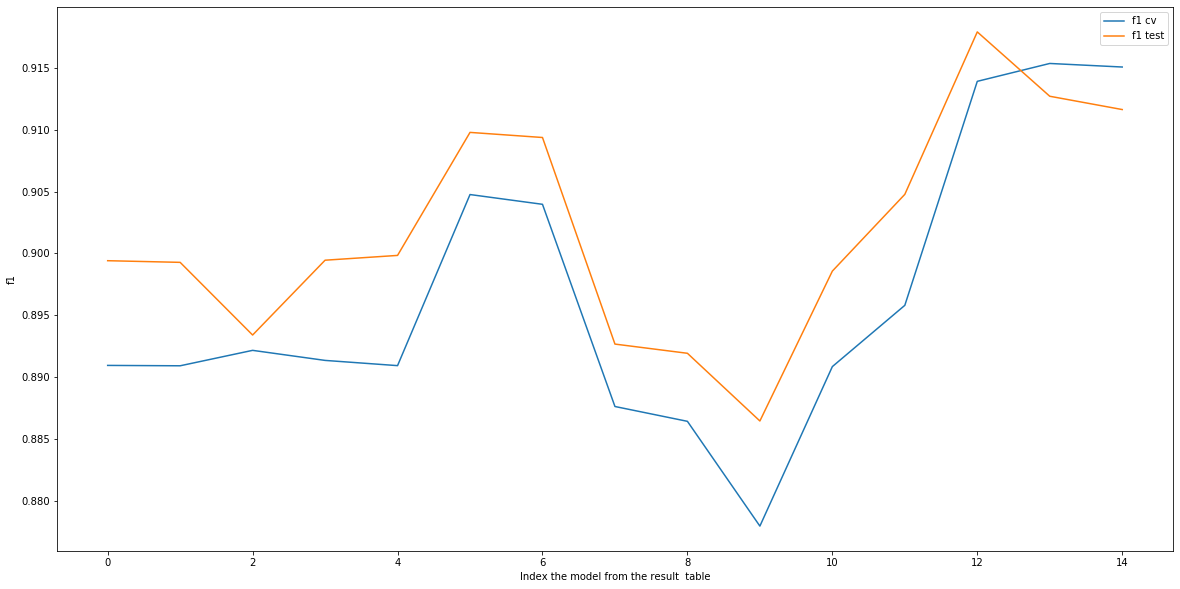

In [164]:
plot_f1_curve(title='',
             lines=(models_research_df['f1 cv'], models_research_df['f1 test']))